# Classification on activations
We saw earlier that activations (from the last token, for some layers) from true and false statements were linearly separable. We will now train try and train a classifier on these activations to see if we can classify true and false statements.

We will start by using only the activations from the layers 10 or 18 which are the most easily separable ones and then we'll try to use the activations from all the layers to see if the classifier still manages to make correct predictions (which would enable a more general way to train it that could be extended to other models easily).

### Load data from 10th layer
We will start by loading the activations from the 10th layer and the labels for the true and false statements.

In [51]:
import pandas as pd


def load_nth_layer_data(nth, dataset='cities', model='gemma-2b-it'):
    data_path = f'../data/activations/{dataset}/{model}_layer_{nth}_output.csv'
    data = pd.read_csv(data_path, header=None, dtype=str)

    # If data has column names, we drop them
    if 'neuron' in str(data.iloc[0, 0]):
        # print('Dropping column names')
        data = data.iloc[1:]

    nb_neurons_by_layer = data.shape[1] - 1
    columns = [f'neuron_{nth*nb_neurons_by_layer + i}' for i in range(nb_neurons_by_layer)] + ['label']
    data.columns = columns

    # Convert activation values to float and labels to int
    data = data.astype(float)
    data['label'] = data['label'].astype(int)

    # Add column corresponding to the dataset name
    data['dataset'] = dataset

    return data

data = load_nth_layer_data(0, 'cities', 'Qwen1.5-0.5B')

print(f'Data contains {data.shape[1] - 2} activation values for {data.shape[0]} statements')
print('The column before the last one contains the labels (1 for true, 0 for false)')

Data contains 1024 activation values for 1496 statements
The column before the last one contains the labels (1 for true, 0 for false)


### Train a classifier
The first classifier we will use is a logistic regression that fits well the binary classification problem we have here.

In [52]:
from sklearn.metrics import accuracy_score


def get_accuracy(clf, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


nth = 10
data = load_nth_layer_data(nth, 'cities', 'Qwen1.5-0.5B')

clf = LogisticRegression(max_iter=1000)
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=['label', 'dataset']), data['label'], test_size=0.2)
accuracy = get_accuracy(clf, x_train, y_train, x_test, y_test)
print(f'Accuracy of {clf.__class__.__name__} on layer {nth} activations: {accuracy:.2f}')

Accuracy of LogisticRegression on layer 10 activations: 0.92


We can also try to train a Random Forest classifier.

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


nth = 10
data = load_nth_layer_data(nth, 'cities', 'Qwen1.5-0.5B')

clf = RandomForestClassifier()
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=['label', 'dataset']), data['label'], test_size=0.2)
print(f'Accuracy of {clf.__class__.__name__} on layer {nth} activations: {accuracy:.2f}')

Accuracy of RandomForestClassifier on layer 10 activations: 0.92


### Plotting accuracy

We can first plot the accuracy on the 'cities' dataset for classifiers trained on the same dataset.

c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


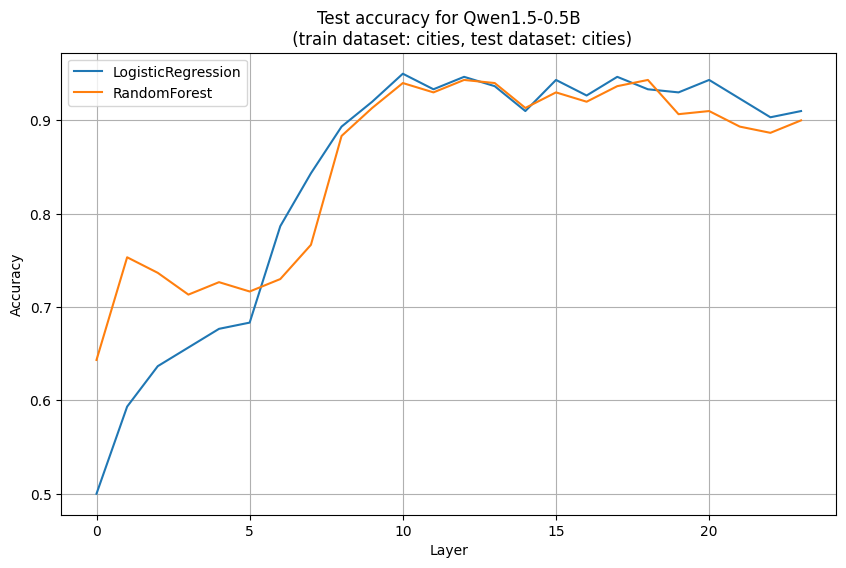

In [58]:
import matplotlib.pyplot as plt

layers = list(range(0, 24))
model = 'Qwen1.5-0.5B'

train_dataset = 'cities'
test_dataset = 'cities'

clfs = [LogisticRegression(max_iter=1000), RandomForestClassifier()]

accuracies = {clf.__class__.__name__: [] for clf in clfs}

for nth in layers:
    train_data = load_nth_layer_data(nth, train_dataset, model)
    x_train, x_test, y_train, y_test = train_test_split(train_data.drop(columns=['label', 'dataset']), train_data['label'], test_size=0.2)
    if train_dataset != test_dataset:
        test_data = load_nth_layer_data(nth, test_dataset, model)
        _, x_test, _, y_test = train_test_split(test_data.drop(columns=['label', 'dataset']), test_data['label'], test_size=0.2)

    for clf in clfs:
        accuracy = get_accuracy(clf, x_train, y_train, x_test, y_test)
        accuracies[clf.__class__.__name__].append(accuracy)

plt.figure(figsize=(10, 6))
for clf, acc in accuracies.items():
    plt.plot(layers, acc, label=clf.replace('Classifier', ''))
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.title(f'Test accuracy for {model}\n \
    (train dataset: {train_dataset}, test dataset: {test_dataset})')
plt.legend()
plt.grid()
plt.show()

We can now do the same thing but with a test set that contains different type of statements.

c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


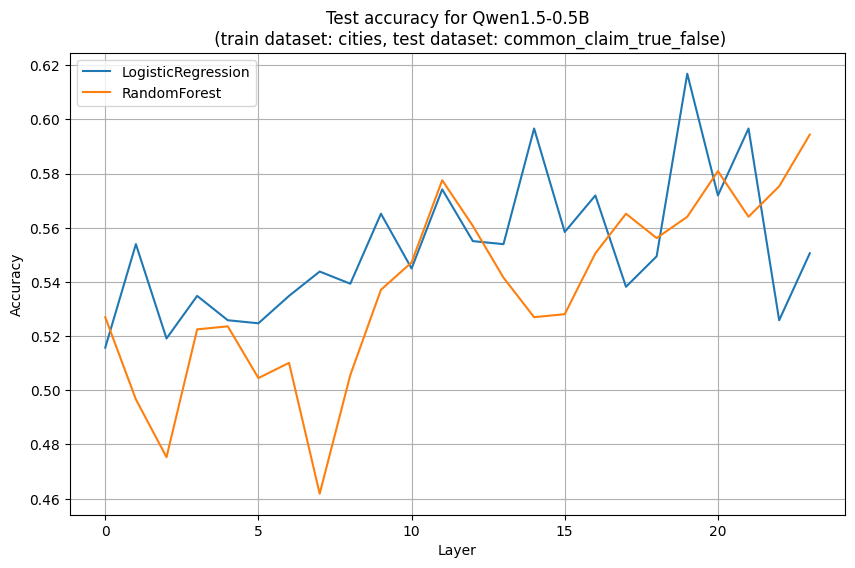

In [59]:
import matplotlib.pyplot as plt

layers = list(range(0, 24))
model = 'Qwen1.5-0.5B'

train_dataset = 'cities'
test_dataset = 'common_claim_true_false'

clfs = [LogisticRegression(max_iter=1000), RandomForestClassifier()]

accuracies = {clf.__class__.__name__: [] for clf in clfs}

for nth in layers:
    train_data = load_nth_layer_data(nth, train_dataset, model)
    x_train, x_test, y_train, y_test = train_test_split(train_data.drop(columns=['label', 'dataset']), train_data['label'], test_size=0.2)
    if train_dataset != test_dataset:
        test_data = load_nth_layer_data(nth, test_dataset, model)
        _, x_test, _, y_test = train_test_split(test_data.drop(columns=['label', 'dataset']), test_data['label'], test_size=0.2)

    for clf in clfs:
        accuracy = get_accuracy(clf, x_train, y_train, x_test, y_test)
        accuracies[clf.__class__.__name__].append(accuracy)

plt.figure(figsize=(10, 6))
for clf, acc in accuracies.items():
    plt.plot(layers, acc, label=clf.replace('Classifier', ''))
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.title(f'Test accuracy for {model}\n \
    (train dataset: {train_dataset}, test dataset: {test_dataset})')
plt.legend()
plt.grid()
plt.show()

We can also try to train and test on a dataset that contains statements from several different datasets.

In [67]:
def load_mixed_data(layers, datasets, model):
    mixed_datasets = [pd.concat([load_nth_layer_data(nth, dataset, model) for dataset in datasets], axis=0).sample(frac=1).reset_index(drop=True) for nth in layers]
    return mixed_datasets

In [68]:
layers = list(range(0, 24))
datasets = ['cities', 'common_claim_true_false']
mixed_datasets = load_mixed_data(layers, datasets, 'Qwen1.5-0.5B')

print(f'Loaded {len(layers)} layers activations for {len(datasets)} datasets')
print(f'Each layer has {mixed_datasets[0].shape[1] - 2} activation values for {mixed_datasets[0].shape[0]} statements')

Loaded 24 layers activations for 2 datasets
Each layer has 1024 activation values for 5946 statements


c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

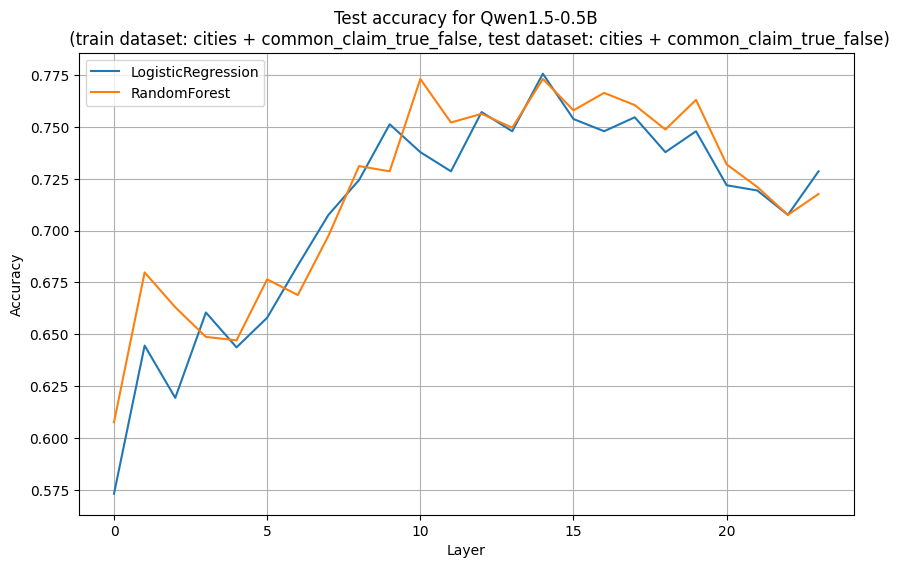

In [73]:
import matplotlib.pyplot as plt

layers = list(range(0, 24))
model = 'Qwen1.5-0.5B'

clfs = [LogisticRegression(max_iter=1000), RandomForestClassifier()]

accuracies = {clf.__class__.__name__: [] for clf in clfs}

for i, nth in enumerate(layers):
    train_data = mixed_datasets[i]
    x_train, x_test, y_train, y_test = train_test_split(train_data.drop(columns=['label', 'dataset']), train_data['label'], test_size=0.2)

    for clf in clfs:
        accuracy = get_accuracy(clf, x_train, y_train, x_test, y_test)
        accuracies[clf.__class__.__name__].append(accuracy)

plt.figure(figsize=(10, 6))
for clf, acc in accuracies.items():
    plt.plot(layers, acc, label=clf.replace('Classifier', ''))
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.title(f'Test accuracy for {model}\n \
    (train dataset: {" + ".join(datasets)}, test dataset: {" + ".join(datasets)})')
plt.legend()
plt.grid()
plt.show()

### Merging activations from all layers
We will now try to merge the activations from all the layers and train a classifier on these.

In [69]:
def load_merged_data(layers, dataset, model):
    datas = [load_nth_layer_data(nth, dataset, model) for nth in layers]
    for i in range(len(datas) - 1):
        datas[i].drop(['label', 'dataset'], axis=1, inplace=True)

    data = pd.concat(datas, axis=1)
    
    return data

layers = list(range(24))
data = load_merged_data(layers, 'cities', 'Qwen1.5-0.5B')
print(f'Data contains {data.shape[1] - 2} activation values from {len(layers)} layers for {data.shape[0]} statements')
print('The last column contains the labels (1 for true, 0 for false)')

Data contains 24576 activation values from 24 layers for 1496 statements
The last column contains the labels (1 for true, 0 for false)


First on the same test and train set.

In [70]:
layers = list(range(24))
train_dataset = 'cities'
model = 'Qwen1.5-0.5B'

data_train = load_merged_data(layers, train_dataset, model)
x_train, x_test, y_train, y_test = train_test_split(data_train.drop(columns=['label', 'dataset']), data_train['label'], test_size=0.2)

print(f'Training on {train_dataset} dataset, testing on {train_dataset}')
acc = get_accuracy(RandomForestClassifier(), x_train, y_train, x_test, y_test)
print(f'Accuracy of RandomForestClassifier on merged layers activations: {acc:.2f}')

acc = get_accuracy(LogisticRegression(max_iter=1000), x_train, y_train, x_test, y_test)
print(f'Accuracy of LogisticRegression on merged layers activations: {acc:.2f}')

Training on cities dataset, testing on cities
Accuracy of RandomForestClassifier on merged layers activations: 0.93
Accuracy of LogisticRegression on merged layers activations: 0.92


Then on a different test set.

In [71]:
layers = list(range(24))
train_dataset = 'cities'
test_dataset = 'common_claim_true_false'
model = 'Qwen1.5-0.5B'

data_train = load_merged_data(layers, train_dataset, model)
x_train, _, y_train, _ = train_test_split(data_train.drop(columns=['label', 'dataset']), data_train['label'], test_size=0.2)
data_test = load_merged_data(layers, test_dataset, model)
_, x_test, _, y_test = train_test_split(data_test.drop(columns=['label', 'dataset']), data_test['label'], test_size=0.2)

print(f'Training on {train_dataset} dataset, testing on {test_dataset}')
acc = get_accuracy(RandomForestClassifier(), x_train, y_train, x_test, y_test)
print(f'Accuracy of RandomForestClassifier on merged layers activations: {acc:.2f}')

acc = get_accuracy(LogisticRegression(max_iter=1000), x_train, y_train, x_test, y_test)
print(f'Accuracy of LogisticRegression on merged layers activations: {acc:.2f}')

Training on cities dataset, testing on common_claim_true_false
Accuracy of RandomForestClassifier on merged layers activations: 0.50
Accuracy of LogisticRegression on merged layers activations: 0.53


And finally on a dataset that contains statements from several different datasets.

In [72]:
layers = list(range(0, 24))
datasets = ['cities', 'common_claim_true_false']
model = 'Qwen1.5-0.5B'

merged_data1 = load_merged_data(layers, datasets[0], model)
merged_data2 = load_merged_data(layers, datasets[1], model)

mixed_merged_data = pd.concat([merged_data1, merged_data2], axis=0)
# Shuffle
mixed_merged_data = mixed_merged_data.sample(frac=1).reset_index(drop=True)

x_train, x_test, y_train, y_test = train_test_split(mixed_merged_data.drop(columns=['label', 'dataset']), mixed_merged_data['label'], test_size=0.2)

print(f'Training on {" + ".join(datasets)} dataset, testing on {" + ".join(datasets)}')
acc = get_accuracy(RandomForestClassifier(), x_train, y_train, x_test, y_test)
print(f'Accuracy of RandomForestClassifier on merged layers activations: {acc:.2f}')

acc = get_accuracy(LogisticRegression(max_iter=1000), x_train, y_train, x_test, y_test)
print(f'Accuracy of LogisticRegression on merged layers activations: {acc:.2f}')

Training on cities + common_claim_true_false dataset, testing on cities + common_claim_true_false
Accuracy of RandomForestClassifier on merged layers activations: 0.77


c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of LogisticRegression on merged layers activations: 0.72


### Locating the most important activation values
Now we know that the classifiers can make accurate predictions using the activations from all the layers, we can try to locate the most important activation values for the classifier.

We can use the feature importance from the Random Forest classifier to see which activations are the most important.

In [80]:
layers = list(range(0, 24, 2))
dataset = 'cities'
model = 'Qwen1.5-0.5B'

data = load_merged_data(layers, dataset, model)
clf = RandomForestClassifier()

# Fit the model on the whole dataset
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=['label', 'dataset']), data['label'], test_size=0.2)
_ = get_accuracy(clf, x_train, y_train, x_test, y_test)

In [81]:
importances = clf.feature_importances_
# Scale the importances between 0 and 1
importances = importances / importances.max()

print(f'Importances shape: {importances.shape}')
nb_activations_by_layer = (data.shape[1] - 2) // len(layers)
importances = importances.reshape(len(layers), nb_activations_by_layer)
print(f'Importances shape after reshaping: {importances.shape}')

most_important_activation = importances.argmax()
print(f'Most important activation is at position {most_important_activation % nb_activations_by_layer} in layer {layers[most_important_activation // nb_activations_by_layer]}')

importances_sums = importances.sum(axis=1)
most_important_layer = importances_sums.argmax()
print(f'Most important layer is {layers[most_important_layer]}')

Importances shape: (12288,)
Importances shape after reshaping: (12, 1024)
Most important activation is at position 433 in layer 14
Most important layer is 14


In [83]:
import numpy as np
import seaborn as sns
import math


def plot_heatmaps(importances, layers, shape):
    original_shape = shape
    importances_reshaped = []
    for i in range(len(importances)):
        importances_reshaped.append(np.array(importances[i]).reshape(original_shape))
    
    ncols = 2
    nrows = math.ceil(len(importances) / ncols)

    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 5.5 * nrows))
    for i, ax in enumerate(axs.flat):
        if i < len(importances):
            ax = sns.heatmap(importances_reshaped[i], cmap='coolwarm', square=False, vmin=0, vmax=1, ax=ax)
            ax.set_title(f'Layer {layers[i]} Activation Importance Heatmap')
            ax.set_xlabel('Neuron x-coordinate')
            ax.set_ylabel('Neuron y-coordinate')
        else:
            fig.delaxes(ax)
    
    plt.tight_layout(pad=2.0)
    plt.show()

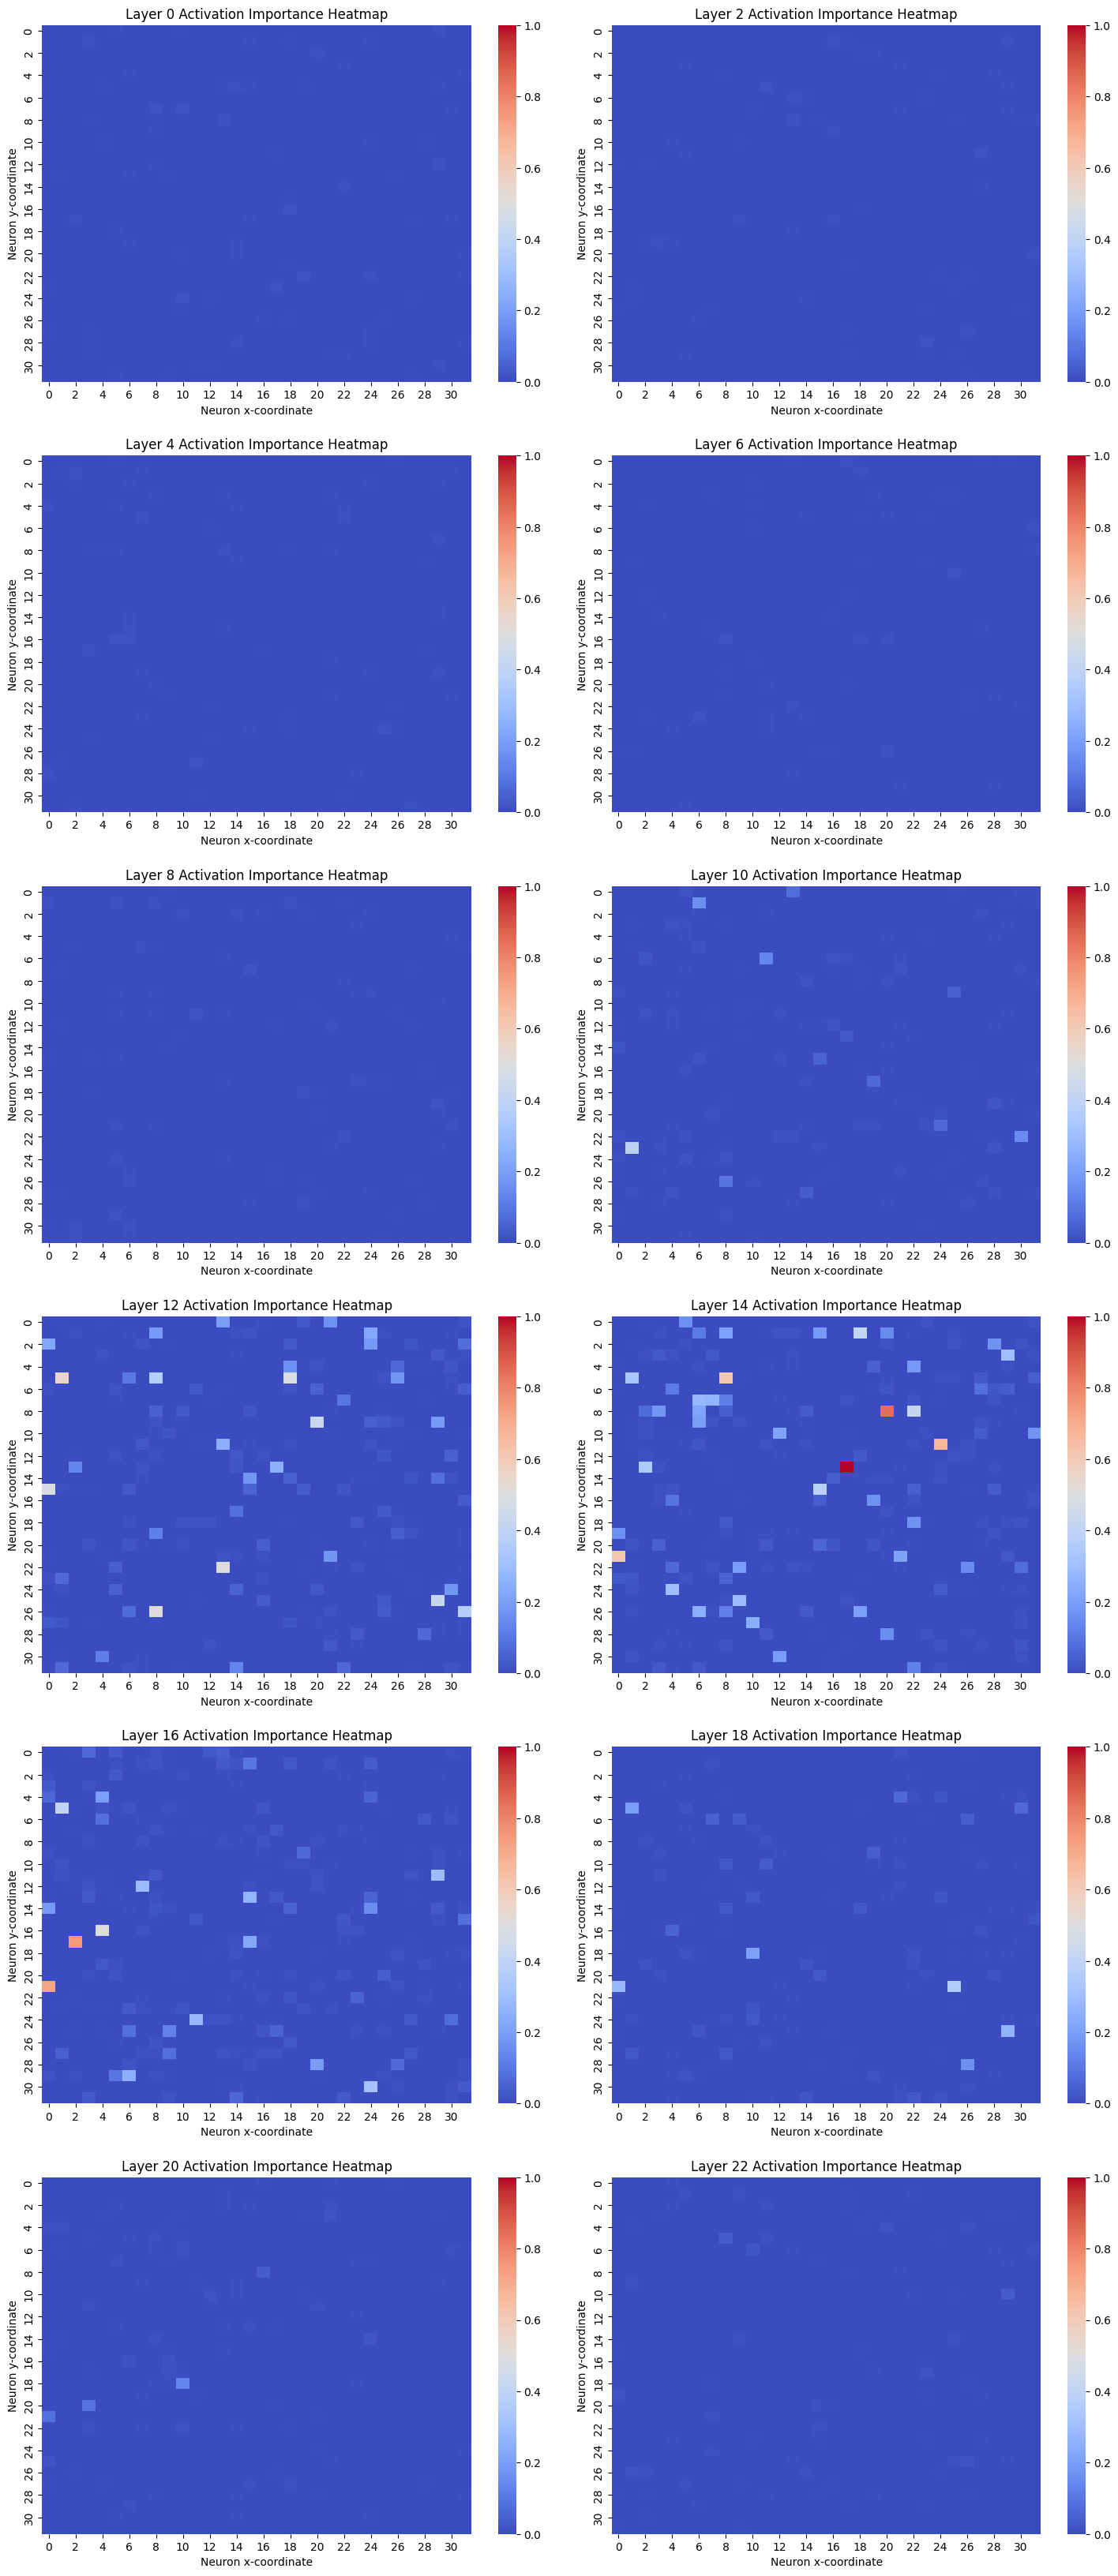

In [84]:
shape = (32, 32)
plot_heatmaps(importances, layers, shape)